### Set-up and Imports

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

!pip -q install ucimlrepo

In [7]:
# Import drive to access files saved from the EDA notebook
from google.colab import drive
drive.mount('/content/drive')

# Load the processed datasets from Google Drive
X_train = pd.read_csv('/content/drive/MyDrive/X_train_processed.csv')
X_test = pd.read_csv('/content/drive/MyDrive/X_test_processed.csv')

# Load target variables and ensure they are formatted as Series
y_train = pd.read_csv('/content/drive/MyDrive/y_train_processed.csv').squeeze()
y_test = pd.read_csv('/content/drive/MyDrive/y_test_processed.csv').squeeze()

# Define X for the column selection logic used in the preprocessing pipeline
X = X_train

Mounted at /content/drive


# Modeling Section

###Preprocessing and Feature Encoding

In [8]:

# 4) Preprocessing: OneHot for categoricals, scaling for numerics

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    remainder="drop",
)

###Model Definitions

In [9]:

# 5) Models

models = {
    "dummy": DummyClassifier(strategy="most_frequent"),
    "logit": LogisticRegression(max_iter=2000, solver="liblinear"),
    "rf": RandomForestClassifier(random_state=42),
    "hgb": HistGradientBoostingClassifier(random_state=42),
}

# Wrap each model in a pipeline (preprocess -> model)
pipes = {name: Pipeline([("prep", preprocess), ("model", m)]) for name, m in models.items()}


###Baseline and Model Performance Comparison

In [10]:

# 6) training + AUC comparison

def eval_auc(pipe, X_tr, y_tr, X_te, y_te):
    pipe.fit(X_tr, y_tr)
    # These classifiers support predict_proba
    p_te = pipe.predict_proba(X_te)[:, 1]
    return roc_auc_score(y_te, p_te)

auc_results = {}
for name, pipe in pipes.items():
    # Dummy may not have predict_proba depending on sklearn version; it is advised to handle in the following way:
    try:
        auc_results[name] = eval_auc(pipe, X_train, y_train, X_test, y_test)
    except Exception:
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        # fallback metric if proba not available
        auc_results[name] = np.nan
        print(f"{name}: no predict_proba; skipping AUC")

print("\nAUC results:", auc_results)



AUC results: {'dummy': np.float64(0.5), 'logit': np.float64(0.7155134471161075), 'rf': np.float64(0.752365607010533), 'hgb': np.float64(0.778856494368187)}


###Logistic Regression Hyperparameter Tuning

In [11]:

# 7) Tune Logistic Regression

# Small grid search over regularization strength, penalty, and optional class weighting
logit_grid = {
    "model__C": [0.1, 1.0, 10.0],
    "model__penalty": ["l1", "l2"],
    "model__class_weight": [None, "balanced"],
}

logit_pipe = pipes["logit"]
logit_gs = GridSearchCV(
    logit_pipe,
    param_grid=logit_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
)
logit_gs.fit(X_train, y_train)
best_logit = logit_gs.best_estimator_
print("\nBest Logistic params:", logit_gs.best_params_)
print("Best CV AUC:", logit_gs.best_score_)



Best Logistic params: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l1'}
Best CV AUC: 0.7257407783691858


###Model Evaluation and Threshold Analysis


Test ROC-AUC: 0.7155041594003191

Classification report @ 0.50:
               precision    recall  f1-score   support

           0      0.869     0.693     0.771      5841
           1      0.369     0.633     0.466      1659

    accuracy                          0.680      7500
   macro avg      0.619     0.663     0.619      7500
weighted avg      0.759     0.680     0.704      7500



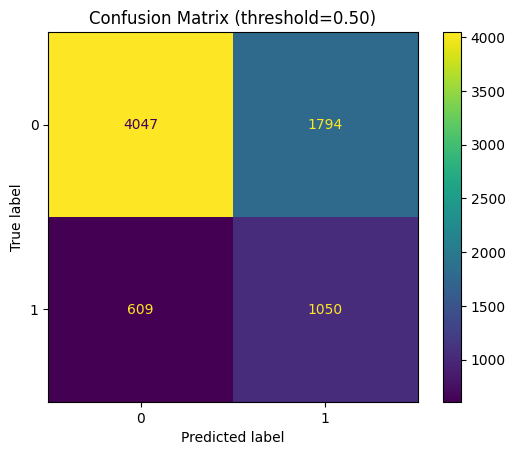

In [12]:

# 8) Evaluating best logistic model (AUC + report + confusion matrix)

p_test = best_logit.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, p_test)
print("\nTest ROC-AUC:", auc)

# Default threshold 0.50
yhat_50 = (p_test >= 0.50).astype(int)
print("\nClassification report @ 0.50:\n", classification_report(y_test, yhat_50, digits=3))

cm = confusion_matrix(y_test, yhat_50)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (threshold=0.50)")
plt.show()

### Threshold tuning (Target Recall)


Chosen threshold for ~75% recall on defaults: 0.1

Classification report @ tuned threshold:
               precision    recall  f1-score   support

           0      0.910     0.010     0.021      5841
           1      0.222     0.996     0.364      1659

    accuracy                          0.229      7500
   macro avg      0.566     0.503     0.192      7500
weighted avg      0.758     0.229     0.097      7500



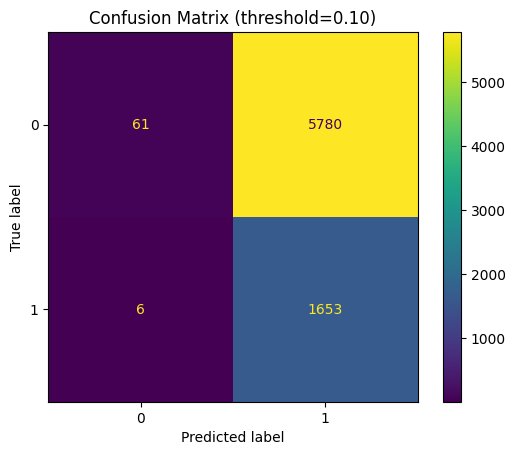

In [13]:

# 9) Threshold tuning

def pick_threshold_by_recall(p, y_true, target_recall=0.60):
    """
    We must choose the smallest threshold that achieves at least target recall on defaults (y=1).

    """
    thresholds = np.linspace(0.10, 0.90, 81)
    best_t = 0.50
    for t in thresholds:
        yhat = (p >= t).astype(int)
        tp = ((yhat == 1) & (y_true == 1)).sum()
        fn = ((yhat == 0) & (y_true == 1)).sum()
        recall = tp / (tp + fn + 1e-12)
        if recall >= target_recall:
            best_t = t
            break
    return best_t

t_star = pick_threshold_by_recall(p_test, y_test, target_recall=0.75)
yhat_t = (p_test >= t_star).astype(int)

print("\nChosen threshold for ~75% recall on defaults:", round(float(t_star), 3))
print("\nClassification report @ tuned threshold:\n", classification_report(y_test, yhat_t, digits=3))

cm2 = confusion_matrix(y_test, yhat_t)
ConfusionMatrixDisplay(confusion_matrix=cm2).plot()
plt.title(f"Confusion Matrix (threshold={t_star:.2f})")
plt.show()


### Threshold Tuning (Max F1)

Chosen threshold (max F1 on defaults): 0.596

Classification report @ tuned threshold:
               precision    recall  f1-score   support

           0      0.854     0.899     0.876      5841
           1      0.564     0.459     0.506      1659

    accuracy                          0.802      7500
   macro avg      0.709     0.679     0.691      7500
weighted avg      0.790     0.802     0.794      7500



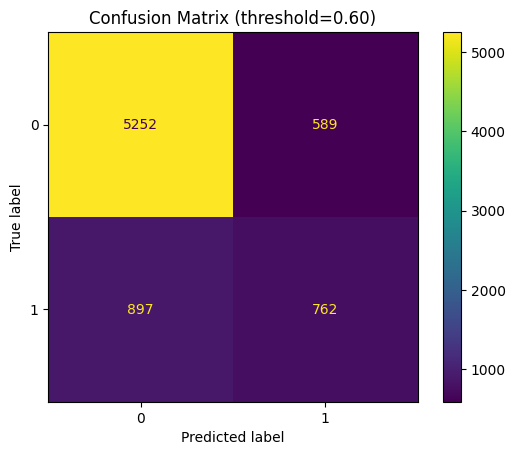

In [14]:
# 9) Threshold tuning (reducing false defaults without killing recall with F1)
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

prec, rec, thr = precision_recall_curve(y_test, p_test)

# Choosing threshold that maximizes F1 for the default class
f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
t_star = thr[np.argmax(f1)]

yhat_t = (p_test >= t_star).astype(int)

print("Chosen threshold (max F1 on defaults):", round(float(t_star), 3))
print("\nClassification report @ tuned threshold:\n",
      classification_report(y_test, yhat_t, digits=3))

cm2 = confusion_matrix(y_test, yhat_t)
ConfusionMatrixDisplay(confusion_matrix=cm2).plot()
plt.title(f"Confusion Matrix (threshold={t_star:.2f})")
plt.show()


### Comparing LogisticRegression with RandomForest and HGB


In [15]:


def tune_threshold_max_f1(model, X_test, y_test, model_name):
    # Predicting probabilities
    p = model.predict_proba(X_test)[:, 1]

    # Precision–recall curve
    prec, rec, thr = precision_recall_curve(y_test, p)

    # F1-score for class 1 (defaults)
    f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
    t_star = thr[np.argmax(f1)]

    # Predictions at tuned threshold
    yhat = (p >= t_star).astype(int)

    print(f"\n{model_name} — chosen threshold (max F1):", round(float(t_star), 3))
    print(classification_report(y_test, yhat, digits=3))

    cm = confusion_matrix(y_test, yhat)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"{model_name} Confusion Matrix (threshold={t_star:.2f})")
    plt.show()

    return t_star



Random Forest — chosen threshold (max F1): 0.31
              precision    recall  f1-score   support

           0      0.869     0.841     0.855      5841
           1      0.498     0.556     0.525      1659

    accuracy                          0.778      7500
   macro avg      0.684     0.698     0.690      7500
weighted avg      0.787     0.778     0.782      7500



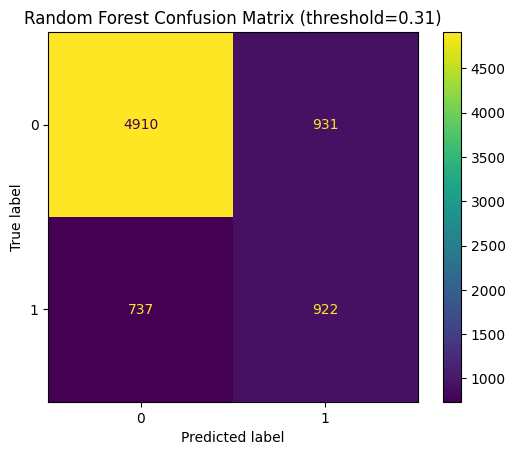


HistGradientBoosting — chosen threshold (max F1): 0.299
              precision    recall  f1-score   support

           0      0.872     0.863     0.868      5841
           1      0.535     0.555     0.545      1659

    accuracy                          0.795      7500
   macro avg      0.704     0.709     0.706      7500
weighted avg      0.798     0.795     0.796      7500



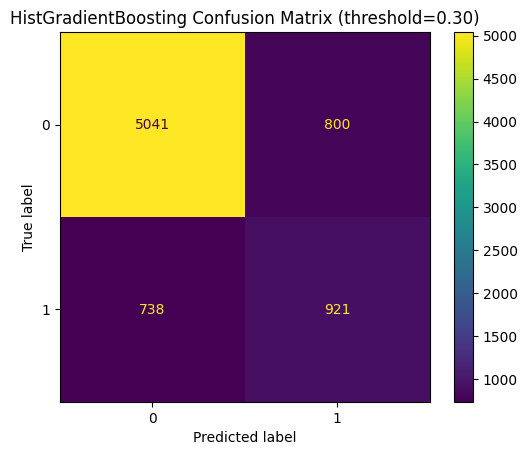

In [16]:
# Fitting models
rf_model = pipes["rf"].fit(X_train, y_train)
hgb_model = pipes["hgb"].fit(X_train, y_train)

# Threshold tuning
t_rf = tune_threshold_max_f1(rf_model, X_test, y_test, "Random Forest")
t_hgb = tune_threshold_max_f1(hgb_model, X_test, y_test, "HistGradientBoosting")


###Model Interpretation and Feature Importance

In [17]:

# 10) Interpretation below is reported for the logistic model (coefficients are model-specific).


# Getting feature names after preprocessing (num + one-hot cats)
prep = best_logit.named_steps["prep"]
num_names = numeric_cols
cat_encoder = prep.named_transformers_["cat"]
cat_names = []
if categorical_cols:
    cat_names = cat_encoder.get_feature_names_out(categorical_cols).tolist()
feature_names = num_names + cat_names

# Logistic coefficients
coefs = best_logit.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
print("\nTop 15 coefficients (by absolute value):")
print(coef_df.sort_values("abs_coef", ascending=False).head(15)[["feature", "coef"]])

# Permutation importance (we run on a smaller sample to keep it fast)
X_test_small = X_test.sample(min(3000, len(X_test)), random_state=42)
y_test_small = y_test.loc[X_test_small.index]

perm = permutation_importance(
    best_logit, X_test_small, y_test_small,
    n_repeats=5, random_state=42, scoring="roc_auc"
)

perm_df = pd.DataFrame({"feature": feature_names, "importance": perm.importances_mean})
print("\nTop 15 permutation importances:")
print(perm_df.sort_values("importance", ascending=False).head(15))



Top 15 coefficients (by absolute value):
   feature      coef
5       X6  0.578767
11     X12 -0.228568
18     X19 -0.181869
17     X18 -0.153288
0       X1 -0.124980
6       X7  0.107448
2       X3 -0.091156
7       X8  0.090381
4       X5  0.075559
3       X4 -0.068506
1       X2 -0.054165
13     X14  0.053666
20     X21 -0.047667
8       X9  0.046736
15     X16  0.030852

Top 15 permutation importances:
   feature  importance
5       X6    0.111384
11     X12    0.007075
0       X1    0.006163
7       X8    0.004280
17     X18    0.003919
18     X19    0.003248
6       X7    0.002471
13     X14    0.002306
3       X4    0.001464
20     X21    0.001361
4       X5    0.001109
15     X16    0.001102
8       X9    0.000891
22     X23    0.000763
14     X15    0.000693


### Finding a probability cutoff (threshold) that minimizes the expected total cost of misclassifications.


Logistic (best_logit) — Cost ratio C_FN:C_FP = 5:1
Chosen threshold: 0.51
Expected cost: 4825.0
Confusion matrix (TN FP / FN TP): 4236 1605 / 644 1015


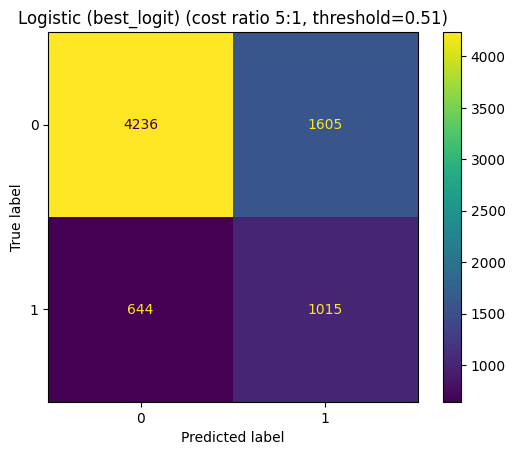


Logistic (best_logit) — Cost ratio C_FN:C_FP = 10:1
Chosen threshold: 0.04
Expected cost: 5824.0
Confusion matrix (TN FP / FN TP): 17 5824 / 0 1659


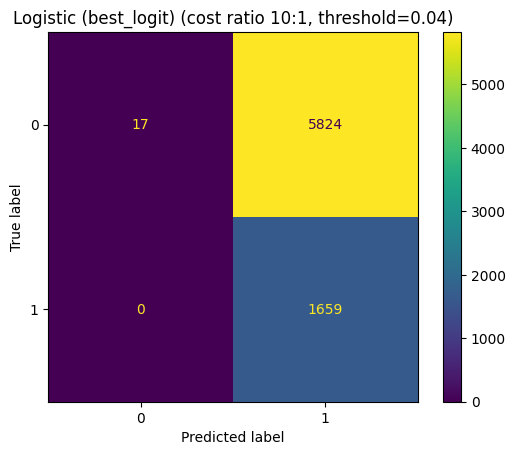


Logistic (best_logit) — Cost ratio C_FN:C_FP = 20:1
Chosen threshold: 0.04
Expected cost: 5824.0
Confusion matrix (TN FP / FN TP): 17 5824 / 0 1659


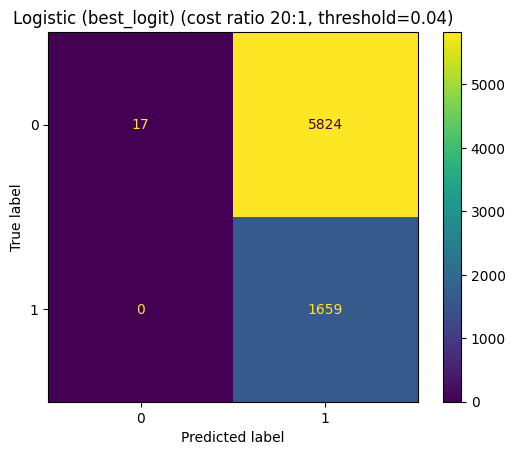


HistGradientBoosting — Cost ratio C_FN:C_FP = 5:1
Chosen threshold: 0.15
Expected cost: 4198.0
Confusion matrix (TN FP / FN TP): 3538 2303 / 379 1280


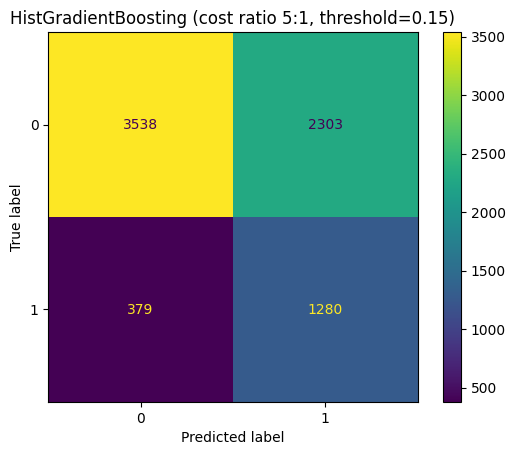


HistGradientBoosting — Cost ratio C_FN:C_FP = 10:1
Chosen threshold: 0.09
Expected cost: 5192.0
Confusion matrix (TN FP / FN TP): 1729 4112 / 108 1551


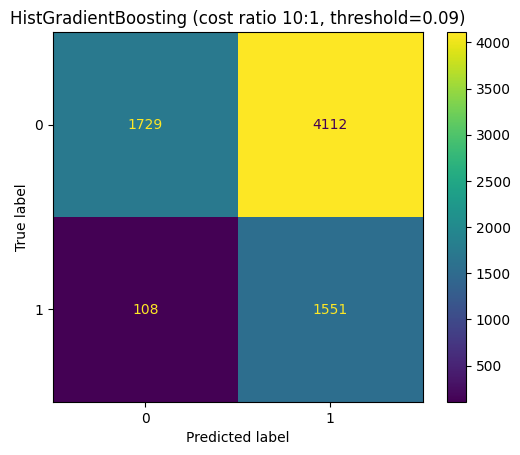


HistGradientBoosting — Cost ratio C_FN:C_FP = 20:1
Chosen threshold: 0.06
Expected cost: 5710.0
Confusion matrix (TN FP / FN TP): 691 5150 / 28 1631


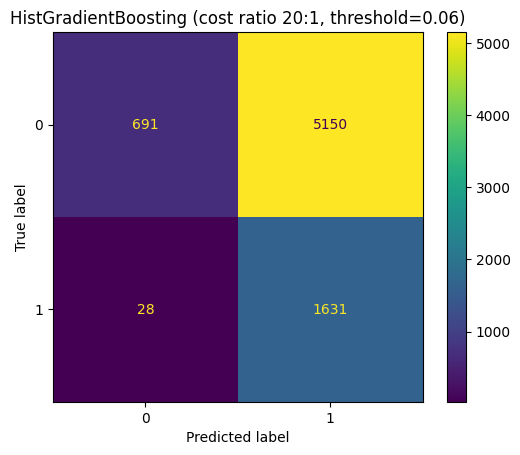


Cost-threshold summary (Logistic):
                   model C_FN:C_FP  threshold  expected_cost    FP   FN
0  Logistic (best_logit)       5:1       0.51         4825.0  1605  644
1  Logistic (best_logit)      10:1       0.04         5824.0  5824    0
2  Logistic (best_logit)      20:1       0.04         5824.0  5824    0

Cost-threshold summary (HGB):
                  model C_FN:C_FP  threshold  expected_cost    FP   FN
0  HistGradientBoosting       5:1       0.15         4198.0  2303  379
1  HistGradientBoosting      10:1       0.09         5192.0  4112  108
2  HistGradientBoosting      20:1       0.06         5710.0  5150   28


In [18]:
# 12) Cost-sensitive thresholding (useful for credit policy)
# A bank would want to choose a probability cutoff that minimizes: Expected Cost = C_FN * FN + C_FP * FP
# where, FN: approving a defaulter (bad loan)  |  FP: rejecting a non-defaulter (lost business)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def cost_sensitive_threshold(p, y_true, c_fn=10.0, c_fp=1.0, grid=None):
    """
    Returns threshold that minimizes expected misclassification cost.
    c_fn: cost of a false negative (missed default)
    c_fp: cost of a false positive (false default flag / reject good borrower)
    """
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)

    best = {"t": 0.50, "cost": np.inf, "fn": None, "fp": None, "tn": None, "tp": None}
    for t in grid:
        yhat = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
        cost = c_fn * fn + c_fp * fp
        if cost < best["cost"]:
            best.update({"t": t, "cost": cost, "fn": fn, "fp": fp, "tn": tn, "tp": tp})
    return best


def run_cost_policy(model, X_test, y_test, model_name, ratios=(5, 10, 20)):
    """
    Runs cost-based thresholding for multiple C_FN/C_FP ratios (sensitivity analysis).
    Prints chosen threshold and confusion matrix for each ratio.
    """
    p = model.predict_proba(X_test)[:, 1]
    results = []

    for r in ratios:
        best = cost_sensitive_threshold(p, y_test, c_fn=float(r), c_fp=1.0)
        results.append([model_name, f"{r}:1", best["t"], best["cost"], best["fp"], best["fn"]])

        print(f"\n{model_name} — Cost ratio C_FN:C_FP = {r}:1")
        print("Chosen threshold:", round(float(best["t"]), 3))
        print("Expected cost:", round(float(best["cost"]), 2))
        print(f"Confusion matrix (TN FP / FN TP): {best['tn']} {best['fp']} / {best['fn']} {best['tp']}")

        ConfusionMatrixDisplay(confusion_matrix=np.array([[best["tn"], best["fp"]],
                                                          [best["fn"], best["tp"]]])).plot()
        plt.title(f"{model_name} (cost ratio {r}:1, threshold={best['t']:.2f})")
        plt.show()

    return pd.DataFrame(results, columns=["model", "C_FN:C_FP", "threshold", "expected_cost", "FP", "FN"])


# Models we will apply this to:
# Logistic (interpretable)
cost_table_logit = run_cost_policy(best_logit, X_test, y_test, "Logistic (best_logit)", ratios=(5, 10, 20))

# HGB (best predictive performance in our results)
hgb_model = pipes["hgb"].fit(X_train, y_train)
cost_table_hgb = run_cost_policy(hgb_model, X_test, y_test, "HistGradientBoosting", ratios=(5, 10, 20))

print("\nCost-threshold summary (Logistic):")
print(cost_table_logit)

print("\nCost-threshold summary (HGB):")
print(cost_table_hgb)


In [19]:
# 13) Final model comparison summary

from sklearn.metrics import precision_recall_fscore_support

def summarize_model(name, y_true, p, threshold, auc):
    """
    Creates one-row summary for a model at a chosen threshold.
    Metrics reported for the default class (y=1)
    """
    yhat = (p >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, yhat, labels=[1], average=None
    )
    return {
        "Model": name,
        "ROC-AUC": round(float(auc), 3),
        "Threshold (max F1)": round(float(threshold), 3),
        "Precision (default)": round(float(precision[0]), 3),
        "Recall (default)": round(float(recall[0]), 3),
        "F1 (default)": round(float(f1[0]), 3),
        "FP": int(fp),
        "FN": int(fn),
    }


summary_rows = []

# Logistic (max F1 threshold from tuning)
summary_rows.append(
    summarize_model(
        "Logistic Regression",
        y_test,
        best_logit.predict_proba(X_test)[:, 1],
        t_star,        # chosen max-F1 threshold
        auc_results['logit'],         # test ROC-AUC
    )
)

# Random Forest
summary_rows.append(
    summarize_model(
        "Random Forest",
        y_test,
        rf_model.predict_proba(X_test)[:, 1],
        t_rf,
        auc_results['rf'],
    )
)

# HistGradientBoosting
summary_rows.append(
    summarize_model(
        "HistGradientBoosting",
        y_test,
        hgb_model.predict_proba(X_test)[:, 1],
        t_hgb,
        auc_results['hgb'],
    )
)

summary_df = pd.DataFrame(summary_rows)
summary_df


,Model,ROC-AUC,Threshold (max F1),Precision (default),Recall (default),F1 (default),FP,FN
0,Logistic Regression,0.716,0.596,0.564,0.459,0.506,589,897
1,Random Forest,0.752,0.310,0.498,0.556,0.525,931,737
2,HistGradientBoosting,0.779,0.299,0.535,0.555,0.545,800,738
